## NOTE:
    PART OF PROB4 AND PROB 5 WERE FINISHED AFTER DEADLINE. I DON'T EXPECT SCORE FOR THEM, BUT I APPRECIATE FEEDBACK.

## #1 Make a table with geographic info about top 50 airports

Read CSV files into pandas dataframes

In [1]:
import pandas as pd

top_airport_csv = 'hw_5_data/top_airports.csv'
ICAO_airport_csv = 'hw_5_data/ICAO_airports.csv'
top50_df = pd.read_csv(top_airport_csv)
icao_df = pd.read_csv(ICAO_airport_csv)

# merge two data frames to obtain info for the top 50 airports
merged_df = pd.merge(top50_df, icao_df, how='inner', left_on='ICAO', right_on='ident')

Select columns for city, airport, latitude and longitude info
- City_Airport_Latitude_Longitude_DataFrame (CALL_DF)

In [2]:
call_df = merged_df[['City', 'Airport', 'ICAO', 'latitude_deg', 'longitude_deg']]
call_df.head(3)

,City,Airport,ICAO,latitude_deg,longitude_deg
0,Atlanta,Hartsfield-Jackson Atlanta International Airport,KATL,33.636700,-84.428101
1,Chicago,Chicago O'Hare International Airport,KORD,41.978600,-87.904800
2,Los Angeles,Los Angeles International Airport,KLAX,33.942501,-118.407997


#### Create database AIRPORTS

In [3]:
import sqlite3, os.path

# remove database in case there's already one there
!rm hw_5_data/call.db

connection = sqlite3.connect("hw_5_data/call.db")
cursor = connection.cursor()
sql_cmd = """CREATE TABLE airports (id INTEGER PRIMARY KEY AUTOINCREMENT,
        airport TEXT, city TEXT, icao TEXT, latitude FLOAT, longitude FLOAT)"""
cursor.execute(sql_cmd)

#### Fill into AIRPORTS info for top 50 airports

In [4]:
for row in call_df.values:
    city, airport, icao, lat, lon = row
    sql_cmd = """INSERT INTO airports (airport, city, icao,
    latitude, longitude) VALUES ("{}","{}","{}", {},{})""".format(
        airport, city, icao, str(lat), str(lon))
    cursor.execute(sql_cmd)
    
connection.commit()
connection.close()

## #2 build table to hold historic weather data

In [5]:
# remove database in case there's already one there
!rm hw_5_data/weather.db

connection = sqlite3.connect("hw_5_data/weather.db")
cursor = connection.cursor()
sql_cmd = """CREATE TABLE weather (id INTEGER PRIMARY KEY AUTOINCREMENT, date DATE,
        icao TEXT, min_temp INT, max_temp INT, min_hum INT, max_hum INT, prec FLOAT)"""
cursor.execute(sql_cmd)
connection.commit()
connection.close()

## #3.1 crawler to pull data from Weather Underground

In [6]:
from util import write2csv

In [7]:
# list of top 50 airports
icao_list = call_df['ICAO'].values

In [8]:
#-------------------------------------
# this is just a demo
#
# expect it to be slow
# a faster version is mentioned in the 
# next cell
#-------------------------------------

# timerange just 1 day
tr_2010_mar = pd.date_range('20100301', '20100301')
fn = 'temp/2010_3.csv'

# only looked at the top 10 cities 
# %time write2csv(tr_2010_mar, icao_list[:10], fn) # uncomment to see demo

### fetching URL is slow ... 
- to speed up I used multiprocessing, see 
- later I realized that it's really IO bound so multithreading or asynchronous IO should perform better
- but I already fetched all the data in about 5 hours...will look into asyncio/multithreading when I have finished the homework 

### IMPORTANT: please untar the data files in hw_5_data/weather_data

in bash:

"""

cd hw_5_data/weather_data 

for i in 2008 ... 2016

do 

    tar -xvf $i.tar
    
done

"""

### check_files() then Check if all the data are downloaded (see below)
- also check if every file (for 1 day) has 50 lines (correspond to 50 cities)

In [9]:
import os.path

def check_files():
    tr = pd.date_range('20080101', '20161006')

    ok = True
    for date in tr:
        filename = 'hw_5_data/weather_data/' + date.strftime('%Y') + '/'+ \
                       date.strftime('%Y%m%d')+'.csv'
        if not os.path.isfile(filename):
            print(date.strftime('%Y%m%d') + ' is missing.')
            ok = False
            continue
        f = open(filename)
        num_lines = sum(1 for line in f)
        f.close()
        if num_lines != 50:
            ok = False
            print(date.strftime('%Y%m%d') + ' may be corrupted, number of cities =/= 50.')
    if ok: print('no file corruption/missing')

In [10]:
# this takes about 15s
check_files()

no file corruption/missing


## #3.2 push data to the database

First load all the data into a pandas DataFrame
- this took ~ 30s on my 2014 MacBook Pro
- the next step took ~ 20s 

In [11]:
from util import fetch_df

tr = pd.date_range('20080101', '20161006')
all_df = pd.DataFrame()
for date in tr:
    # fetch data for that day
    if all_df.empty:
        all_df = fetch_df(date)
    else:
        df = fetch_df(date)
        all_df = all_df.append(df, ignore_index=True)
    
# interpolate data to remove NaN
all_df = all_df.fillna(method='pad').fillna(method='bfill')

In [12]:

connection = sqlite3.connect("hw_5_data/weather.db")
cursor = connection.cursor()

#insert data into database
for row in all_df.values:
    date, icao, min_temp, max_temp, min_hum, max_hum, prec = row
    date = pd.to_datetime(date).strftime('%m/%d/%Y')
    
    sql_cmd = """INSERT INTO weather (date, icao, min_temp, max_temp, 
    min_hum, max_hum, prec) VALUES ("{}","{}",{},{},{},{},{})""".format(
        date, icao, min_temp, max_temp, min_hum, max_hum, prec)
    
    cursor.execute(sql_cmd)
    
connection.commit()
connection.close()

## #4 Correlation between weather of cities

In [13]:
import numpy as np
import pandas as pd
import sqlite3

In [67]:
connection = sqlite3.connect("hw_5_data/weather.db")
cursor = connection.cursor()


def temp_prec_corr(n):
    """
    find the correlation between temperature between any two cities with N day shifts.
    """
    import os.path    
    
    # this is the file we are gonna store the correlations
    filename = 'hw_5_data/corr_{}.npy'.format(n)
    
    # skip if .npy file already exist
    
    if os.path.isfile(filename):
        return
    
    temp_corr_arr = []
    prec_corr_arr = []

    for (i, city_1) in enumerate(icao_list):
        for (j, city_2) in enumerate(icao_list):
            sql_cmd = """SELECT max_temp, min_temp, prec FROM weather WHERE icao = "{}" """.format(city_1)
            cursor.execute(sql_cmd)
            city_1_info = np.array(cursor.fetchall())
            high_temp_1 = np.array([int(temp) for temp in city_1_info[:, 0]])
            low_temp_1 = np.array([int(temp) for temp in city_1_info[:, 1]])
            #average temperature
            temp_1 = (high_temp_1 + low_temp_1)/2
            prec_1 = np.array([float(temp) for temp in city_1_info[:, 2]])
            
            # daily change in temperature
            temp_change_1 = np.roll(temp_1, 1) - temp_1
#             prec_change_1 = np.roll(prec_1, 1) - prec_1

            sql_cmd = """SELECT max_temp, min_temp, prec FROM weather WHERE icao = "{}" """.format(city_2)
            cursor.execute(sql_cmd)
            city_2_info = np.array(cursor.fetchall())
            high_temp_2 = np.array([int(temp) for temp in city_2_info[:, 0]])
            low_temp_2 = np.array([int(temp) for temp in city_2_info[:, 1]])
            #average temperature
            temp_2 = (high_temp_2 + low_temp_2)/2            
            prec_2 = np.array([float(temp) for temp in city_2_info[:, 2]])

            # daily change in temperature
            temp_change_2 = np.roll(temp_2, 1) - temp_2
#             prec_change_2 = np.roll(prec_2, 1) - prec_2
            
            t_corr = np.corrcoef(temp_change_1, np.roll(temp_change_2, n))[1, 0]
#             p_corr = np.corrcoef(prec_change_1, np.roll(prec_change_2,n))[1, 0]
            p_corr = np.corrcoef(prec_1, np.roll(prec_2,n))[1, 0]
            
            temp_corr_arr += [t_corr]
            prec_corr_arr += [p_corr]

    corr_n = [temp_corr_arr, prec_corr_arr]
    # save to .npy file for future use
    np.save('hw_5_data/corr_{}'.format(n), corr_n)            
    return corr_n

#### UNCOMMENT the liines below if you want to calculate correlation on your own machine
- It took ~4min on my 2014 MacBook Pro
- I have already saved data files in the data folder so you can also load them directly. just go to the next cell

In [69]:
# !rm -rf hw_5_data/corr_*.npy

# import multiprocessing

# pool = multiprocessing.Pool(processes=3)
# %time result = pool.map(temp_prec_corr, [1, 3, 7])
# pool.close()
# pool.join()

In [70]:
# load data from .npy data file

arr = np.load('hw_5_data/corr_1.npy')
temp_corr_1, prec_corr_1 = arr[0, :], arr[1, :]

arr = np.load('hw_5_data/corr_3.npy')
temp_corr_3, prec_corr_3 = arr[0, :], arr[1, :]

arr = np.load('hw_5_data/corr_7.npy')
temp_corr_7, prec_corr_7 = arr[0, :], arr[1, :]

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
%matplotlib inline

# mpl.style.use('ggplot')
mpl.rcParams['axes.titlesize'] = 20

#### make density plots for correlations

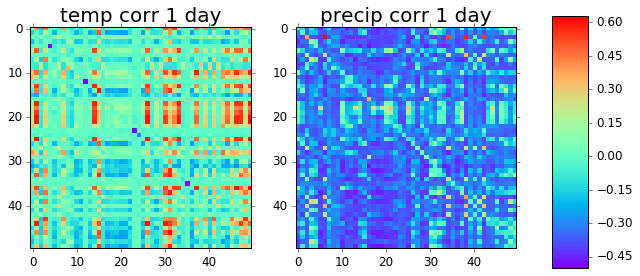

In [72]:
fig1, (ax1, ax2)  = plt.subplots(1,2, figsize=[10, 5])

# num of city
nc = 50
im1 = ax1.imshow(temp_corr_1.reshape(nc, nc), interpolation='nearest',cmap='rainbow')
ax1.set_title('temp corr 1 day')
im2 = ax2.imshow(prec_corr_1.reshape(nc, nc), interpolation='nearest',cmap='rainbow')
ax2.set_title('precip corr 1 day')
# add color bar
fig1.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.05, 0.7])
fig1.colorbar(im1, cax=cbar_ax)

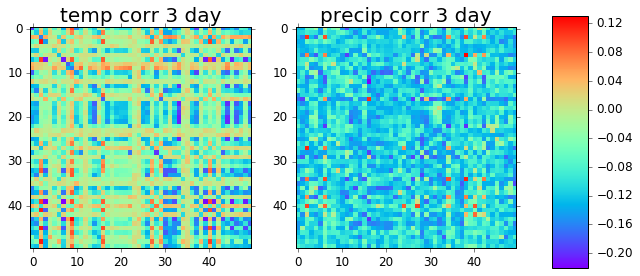

In [73]:
fig3, (ax1, ax2)  = plt.subplots(1,2, figsize=[10, 5])

# num of city
nc = 50
im1 = ax1.imshow(temp_corr_3.reshape(nc, nc), interpolation='nearest',cmap='rainbow')
ax1.set_title('temp corr 3 day')
im2 = ax2.imshow(prec_corr_3.reshape(nc, nc), interpolation='nearest',cmap='rainbow')
ax2.set_title('precip corr 3 day')
# add color bar
fig3.subplots_adjust(right=0.8)
cbar_ax = fig3.add_axes([0.85, 0.15, 0.05, 0.7])
fig3.colorbar(im1, cax=cbar_ax)

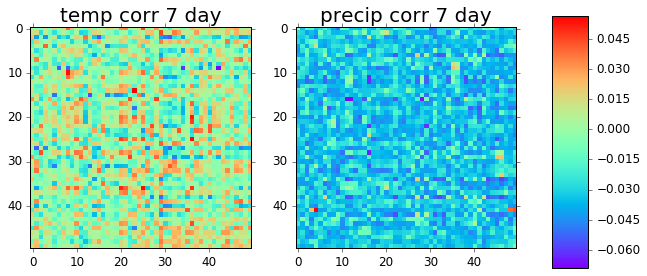

In [74]:
fig7, (ax1, ax2)  = plt.subplots(1,2, figsize=[10, 5])

# num of city
nc = 50
im1 = ax1.imshow(temp_corr_7.reshape(nc, nc), interpolation='nearest',cmap='rainbow')
ax1.set_title('temp corr 7 day')
im2 = ax2.imshow(prec_corr_7.reshape(nc, nc), interpolation='nearest',cmap='rainbow')
ax2.set_title('precip corr 7 day')
# add color bar
fig7.subplots_adjust(right=0.8)
cbar_ax = fig7.add_axes([0.85, 0.15, 0.05, 0.7])
fig7.colorbar(im1, cax=cbar_ax)

## #5 Examine correlation length

In [75]:
def get_ntop_corr(corr_pairs, ntop = 10, nc = 50):
    """
    parameter
    ---------
        corr_pairs: correlation between all city pairs between NC number of cities
            for some weather variable. 
        ntop: number of most correlated city pairs that we want to study
        nc: number of cities --> number of pairs are nc^2
    
    return
    ------
        pandas DataFrame containing info for
            NTOP most correlated pairs of cities with 
            
            city1: 1st city in the pair 
            city2: 2nd city in the pair (whose weather 'is' predicted)
            icao1: ICAO # for the airport near city1
            icao2: ICAO # for the airport near city2
            distance: distance in km between city1 and city2
            corr: correlation coeff
    """

    # index of the N top correlated pairs
    ntop_ind = corr_pairs.argsort()[-ntop:][::-1]
    corr_arr = corr_pairs[ntop_ind]
    
    city1_ind = ntop_ind // nc
    city2_ind = ntop_ind % nc

    city1_arr = call_df['City'][city1_ind].values
    icao1_arr = call_df['ICAO'][city1_ind].values
    city2_arr = call_df['City'][city2_ind].values
    icao2_arr = call_df['ICAO'][city2_ind].values
    lat1_arr = call_df['latitude_deg'][city1_ind].values
    lat2_arr = call_df['latitude_deg'][city2_ind].values
    lon1_arr = call_df['longitude_deg'][city1_ind].values
    lon2_arr = call_df['longitude_deg'][city2_ind].values


    from util import lat_lon_2_distance
    from itertools import starmap

    dist_arr = np.array(list(starmap(lat_lon_2_distance, 
                                 zip(lat1_arr, lon1_arr, lat2_arr, lon2_arr))))
    diff_lon = np.abs(lon1_arr - lon2_arr)

    # build a new dataframe

    return pd.DataFrame({'city 1': city1_arr,
                         'icao 1': icao1_arr,
                         'city 2': city2_arr,
                         'icao 2': icao2_arr,
                         'distance': dist_arr,
                         'diff_lon': diff_lon,
                         'corr': corr_arr
                 })

### 1day correlation

In [76]:
temp_1_df = get_ntop_corr(temp_corr_1)
prec_1_df = get_ntop_corr(prec_corr_1)

In [77]:
# most correlated cities in temperature variation
temp_1_df 

,city 1,city 2,corr,diff_lon,distance,icao 1,icao 2
0,Washington D.C. / Chantilly / Dulles,Indianapolis,0.628613,8.838600,764.963008,KIAD,KIND
1,Raleigh,Indianapolis,0.625759,7.506905,785.521589,KRDU,KIND
2,Baltimore / Glen Burnie,Indianapolis,0.617526,9.626106,828.616366,KBWI,KIND
3,Washington D.C. / Arlington County,Indianapolis,0.616448,9.256706,802.358426,KDCA,KIND
4,Covington,Kansas City,0.615095,10.046097,866.269705,KCVG,KMCI
5,Pittsburgh,Chicago,0.604256,7.519501,645.916265,KPIT,KMDW
6,Baltimore / Glen Burnie,Cleveland,0.603659,5.181503,504.961220,KBWI,KCLE
7,Washington D.C. / Chantilly / Dulles,Chicago,0.602988,10.296600,927.374880,KIAD,KMDW
8,Detroit / Romulus,Minneapolis,0.602362,9.868401,848.511270,KDTW,KMSP
9,Raleigh,Covington,0.601960,5.880302,627.431014,KRDU,KCVG


In [78]:
# most correlated cities in precipitation variation
prec_1_df 

,city 1,city 2,corr,diff_lon,distance,icao 1,icao 2
0,Los Angeles,San Francisco,0.415599,3.967003,543.359798,KLAX,KSFO
1,Los Angeles,Sacramento,0.395354,3.183006,600.610239,KLAX,KSMF
2,Los Angeles,San Jose,0.376426,3.521004,495.885655,KLAX,KSJC
3,Los Angeles,Oakland,0.370884,3.813004,542.929669,KLAX,KOAK
4,Sacramento,Sacramento,0.308837,0.000000,0.000000,KSMF,KSMF
5,Los Angeles,Los Angeles,0.308815,0.000000,0.000000,KLAX,KLAX
6,Seattle / Tacoma (SeaTac),Seattle / Tacoma (SeaTac),0.298381,0.000000,0.000000,KSEA,KSEA
7,Santa Ana,San Francisco,0.296239,4.507004,598.448891,KSNA,KSFO
8,Santa Ana,Sacramento,0.284110,3.723007,650.580264,KSNA,KSMF
9,San Francisco,Sacramento,0.283523,0.783997,137.971679,KSFO,KSMF


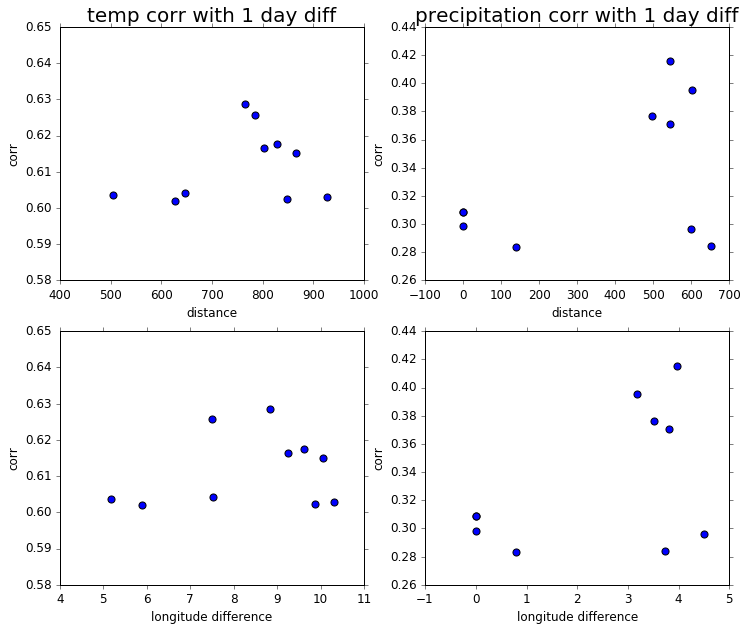

In [79]:
fig1, [[ax1, ax2], [ax3, ax4]]  = plt.subplots(2,2, figsize=[12,10])

ax1.scatter(temp_1_df['distance'], temp_1_df['corr'], s=50)
ax1.set_title('temp corr with 1 day diff')
ax1.set_ylabel('corr')
ax1.set_xlabel('distance')
ax2.scatter(prec_1_df['distance'], prec_1_df['corr'], s=50)
ax2.set_title('precipitation corr with 1 day diff')
ax2.set_ylabel('corr')
ax2.set_xlabel('distance')

ax3.scatter(temp_1_df['diff_lon'], temp_1_df['corr'], s=50)
ax3.set_ylabel('corr')
ax3.set_xlabel('longitude difference')

ax4.scatter(prec_1_df['diff_lon'], prec_1_df['corr'], s=50)
ax4.set_ylabel('corr')
ax4.set_xlabel('longitude difference')

### 3 day correlation

In [80]:
temp_3_df = get_ntop_corr(temp_corr_3)
prec_3_df = get_ntop_corr(prec_corr_3)

In [81]:
# most correlated cities in temperature variation
temp_3_df 

,city 1,city 2,corr,diff_lon,distance,icao 1,icao 2
0,New Orleans,Phoenix,0.130603,21.753998,2089.626486,KMSY,KPHX
1,Dallas-Fort Worth,Los Angeles,0.121051,21.369995,1983.797037,KDFW,KLAX
2,San Antonio,Los Angeles,0.119646,19.938194,1945.255699,KSAT,KLAX
3,Dallas,Los Angeles,0.118751,21.556198,2001.858616,KDAL,KLAX
4,Austin,Los Angeles,0.116271,20.738098,1994.973803,KAUS,KLAX
5,Dallas-Fort Worth,Santa Ana,0.103055,20.829994,1935.466027,KDFW,KSNA
6,Houston,Los Angeles,0.102089,23.066597,2215.768844,KIAH,KLAX
7,Dallas,Santa Ana,0.101807,21.016197,1953.481436,KDAL,KSNA
8,Houston,Los Angeles,0.100626,23.129097,2233.090419,KHOU,KLAX
9,San Antonio,Santa Ana,0.100255,19.398193,1891.326659,KSAT,KSNA


In [82]:
# most correlated cities in precipitation variation
prec_3_df 

,city 1,city 2,corr,diff_lon,distance,icao 1,icao 2
0,San Francisco,Sacramento,0.141351,0.783997,137.971679,KSFO,KSMF
1,Oakland,Sacramento,0.132286,0.629997,121.536728,KOAK,KSMF
2,San Diego,Los Angeles,0.132159,1.217995,175.756439,KSAN,KLAX
3,Seattle / Tacoma (SeaTac),Seattle / Tacoma (SeaTac),0.129511,0.000000,0.000000,KSEA,KSEA
4,Los Angeles,Los Angeles,0.128430,0.000000,0.000000,KLAX,KLAX
5,Santa Ana,San Diego,0.124222,0.677994,122.320182,KSNA,KSAN
6,Santa Ana,Los Angeles,0.123073,0.540001,58.063549,KSNA,KLAX
7,Los Angeles,Sacramento,0.122063,3.183006,600.610239,KLAX,KSMF
8,Oakland,San Francisco,0.121682,0.153999,17.700536,KOAK,KSFO
9,Oakland,Oakland,0.120743,0.000000,0.000000,KOAK,KOAK


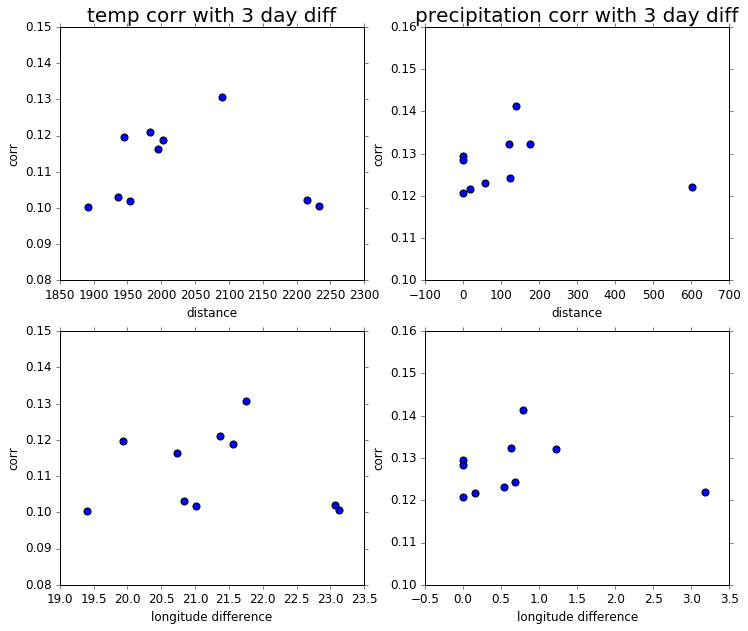

In [85]:
fig3, [[ax1, ax2], [ax3, ax4]]  = plt.subplots(2,2, figsize=[12,10])

ax1.scatter(temp_3_df['distance'], temp_3_df['corr'], s=50)
ax1.set_title('temp corr with 3 day diff')
ax1.set_ylabel('corr')
ax1.set_xlabel('distance')

ax2.scatter(prec_3_df['distance'], prec_3_df['corr'], s=50)
ax2.set_title('precipitation corr with 3 day diff')
ax2.set_ylabel('corr')
ax2.set_xlabel('distance')

ax3.scatter(temp_3_df['diff_lon'], temp_3_df['corr'], s=50)
ax3.set_ylabel('corr')
ax3.set_xlabel('longitude difference')

ax4.scatter(prec_3_df['diff_lon'], prec_3_df['corr'], s=50)
ax4.set_ylabel('corr')
ax4.set_xlabel('longitude difference')

### 7 day correlation

In [86]:
temp_7_df = get_ntop_corr(temp_corr_7)
prec_7_df = get_ntop_corr(prec_corr_7)

# most correlated cities in temperature variation
temp_7_df 

,city 1,city 2,corr,diff_lon,distance,icao 1,icao 2
0,Detroit / Romulus,Salt Lake City,0.056374,28.624596,2378.638011,KDTW,KSLC
1,Washington D.C. / Arlington County,Raleigh,0.054850,1.749802,365.208288,KDCA,KRDU
2,Raleigh,Washington D.C. / Arlington County,0.054714,1.749802,365.208288,KRDU,KDCA
3,Charlotte,Las Vegas,0.053754,34.208900,3077.553506,KCLT,KLAS
4,Washington D.C. / Chantilly / Dulles,Raleigh,0.052073,1.331696,360.837054,KIAD,KRDU
5,Raleigh,Washington D.C. / Chantilly / Dulles,0.049726,1.331696,360.837054,KRDU,KIAD
6,Raleigh,Raleigh,0.048320,0.000000,0.000000,KRDU,KRDU
7,Washington D.C. / Arlington County,Washington D.C. / Chantilly / Dulles,0.046446,0.418106,37.624628,KDCA,KIAD
8,Baltimore / Glen Burnie,Raleigh,0.046431,2.119202,411.668724,KBWI,KRDU
9,Seattle / Tacoma (SeaTac),Tampa,0.046167,39.775795,4052.239783,KSEA,KTPA


In [87]:
# most correlated cities in precipitation variation
prec_7_df 

,city 1,city 2,corr,diff_lon,distance,icao 1,icao 2
0,Austin,Denver,0.167847,7.003098,1249.214854,KAUS,KDEN
1,Austin,Indianapolis,0.143231,11.375496,1479.895768,KAUS,KIND
2,Austin,Dallas,0.135248,0.818100,305.070979,KAUS,KDAL
3,Portland,San Antonio,0.101156,24.128197,2758.141163,KPDX,KSAT
4,Austin,Dallas-Fort Worth,0.100020,0.631897,306.484447,KAUS,KDFW
5,Phoenix,San Juan / Carolina,0.099591,46.010201,4850.129940,KPHX,TJSJ
6,Cleveland,Covington,0.098974,2.818001,355.403899,KCLE,KCVG
7,Portland,Covington,0.098891,37.930199,3171.756984,KPDX,KCVG
8,Oakland,San Diego,0.095485,5.030998,718.584542,KOAK,KSAN
9,San Francisco,San Diego,0.093290,5.184998,719.113447,KSFO,KSAN


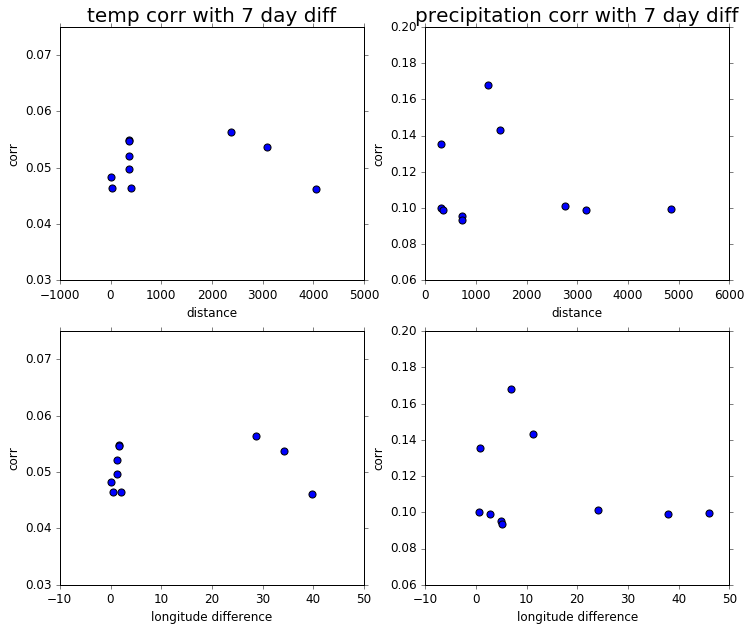

In [88]:
fig7, [[ax1, ax2], [ax3, ax4]]  = plt.subplots(2,2, figsize=[12,10])

ax1.scatter(temp_7_df['distance'], temp_7_df['corr'], s=50)
ax1.set_title('temp corr with 7 day diff')
ax1.set_ylabel('corr')
ax1.set_xlabel('distance')
ax2.scatter(prec_7_df['distance'], prec_7_df['corr'], s=50)

ax2.set_title('precipitation corr with 7 day diff')
ax2.set_ylabel('corr')
ax2.set_xlabel('distance')

ax3.scatter(temp_7_df['diff_lon'], temp_7_df['corr'], s=50)
ax3.set_ylabel('corr')
ax3.set_xlabel('longitude difference')

ax4.scatter(prec_7_df['diff_lon'], prec_7_df['corr'], s=50)
ax4.set_ylabel('corr')
ax4.set_xlabel('longitude difference')

### Note
- I was a bit sloppy in selecting the top 10 most correlated pairs of cities that one pair (Raleigh, Raleigh) sneaks in ... but it should not affect conclusions

Trends (obvious ...)
- Correlation evidently decreases when time dilation increases
- temperature variation is more correlated than precipitation variation. 

Other description
- correlation in temperature variantion is less spatially constraint than correlation  in precipitation (not change in precipitation)
- for 1 day and 7 day time dilation, the temperature correlation is relative high when locations are close (<1000km apart). But for 3 day dilation, temperature correlation peaks at ~2000km. 
- In contrast, precipitation correlation peaks at ~200km distance for 3 day dilation, while evidently larger distance for 1 and 7 day dilation. 